# Fit thick-target bremsstrahlung with bounds
## !!! Uses SRM interpolation function from [here](https://gist.github.com/settwi/60eb4fa884ff9a61cb0d081c93bbb714).

## First we use Nelder-Mead to find a minimum. Then we run MCMC to get errors.

In [1]:
from sunkit_spex.fitting import fit_models, fitters, spectra
import scipy.stats as st

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Define the model data

In [2]:
idx = 4 << u.one
flux = 1e36 << u.electron / u.s
low_cutoff = 20 << u.keV

mod = fit_models.ThickTargetBremsstrahlungSinglePowerLaw()
mod.electron_index.value = idx
mod.electron_flux.value = flux
mod.low_energy_cutoff.value = low_cutoff
mod.current_parameters()

OrderedDict([('electron_index',
              ModelParameter<4.0 | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed909542f0>>),
             ('low_energy_cutoff',
              ModelParameter<20.0 keV | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed90954620>>),
             ('electron_flux',
              ModelParameter<1e+36 electron / s | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed90954740>>)])

## Make a real photon-to-counts SRM and sample the "perfect" counts model

In [3]:
try:
    import rebin_flux
except ImportError:
    raise RuntimeError("Download the script from the start of the file")

photon_edges = np.logspace(np.log10(1), np.log10(800), num=2048) << u.keV
count_edges = np.logspace(np.log10(3), np.log10(200), num=32) << u.keV

area = 100 << u.cm**2
square_srm = np.eye(photon_edges.size-1) * np.linspace(1, 0.5, num=photon_edges.size-1)

rebinned_srm = []
for row in square_srm:
    new = rebin_flux.flux_conserving_rebin(
        photon_edges.value,
        row,
        count_edges.value
    )
    rebinned_srm.append(new)

srm = area * (np.array(rebinned_srm).T << u.ct / u.ph)

In [4]:
# Evaluate model as counts model & compare
photon_model = mod.evaluate(photon_edges)

exposure = 10 << u.s
ph_de = np.diff(photon_edges)
perfect_counts = ((srm @ (photon_model * ph_de)) * exposure) << u.ct
ugly_counts = st.poisson.rvs(perfect_counts.to_value(u.ct)) << u.ct

In [5]:
spectrum = spectra.XraySpectrum(
    ugly_counts,
    np.sqrt(ugly_counts.value) << u.ct,
    count_edges,
    photon_edges,
    srm,
    exposure
)

## Define the model for fitting
### Parameter bounds may be set, or you can set the `prior_distribution` of each `ModelParameter`.
### "Setting bounds" is a convenience function--it makes the parameter prior distribution uniform between the boudaries.

In [6]:
mod = fit_models.ThickTargetBremsstrahlungSinglePowerLaw()

# Units assumed to be the same as defined in model
mod.electron_flux.value = 1e36
mod.electron_flux.set_bounds(1e30, 1e40)

mod.electron_index.value = 5
mod.electron_index.set_bounds(2, 10)

mod.low_energy_cutoff.value = 15
mod.low_energy_cutoff.set_bounds(2, 50)

mod.current_parameters()

OrderedDict([('electron_index',
              ModelParameter<5.0 | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fee1eb5fe30>>),
             ('low_energy_cutoff',
              ModelParameter<15.0 keV | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed90955be0>>),
             ('electron_flux',
              ModelParameter<1e+36 electron / s | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed9277ecc0>>)])

### Plot the model on top of the data to see if things make sense

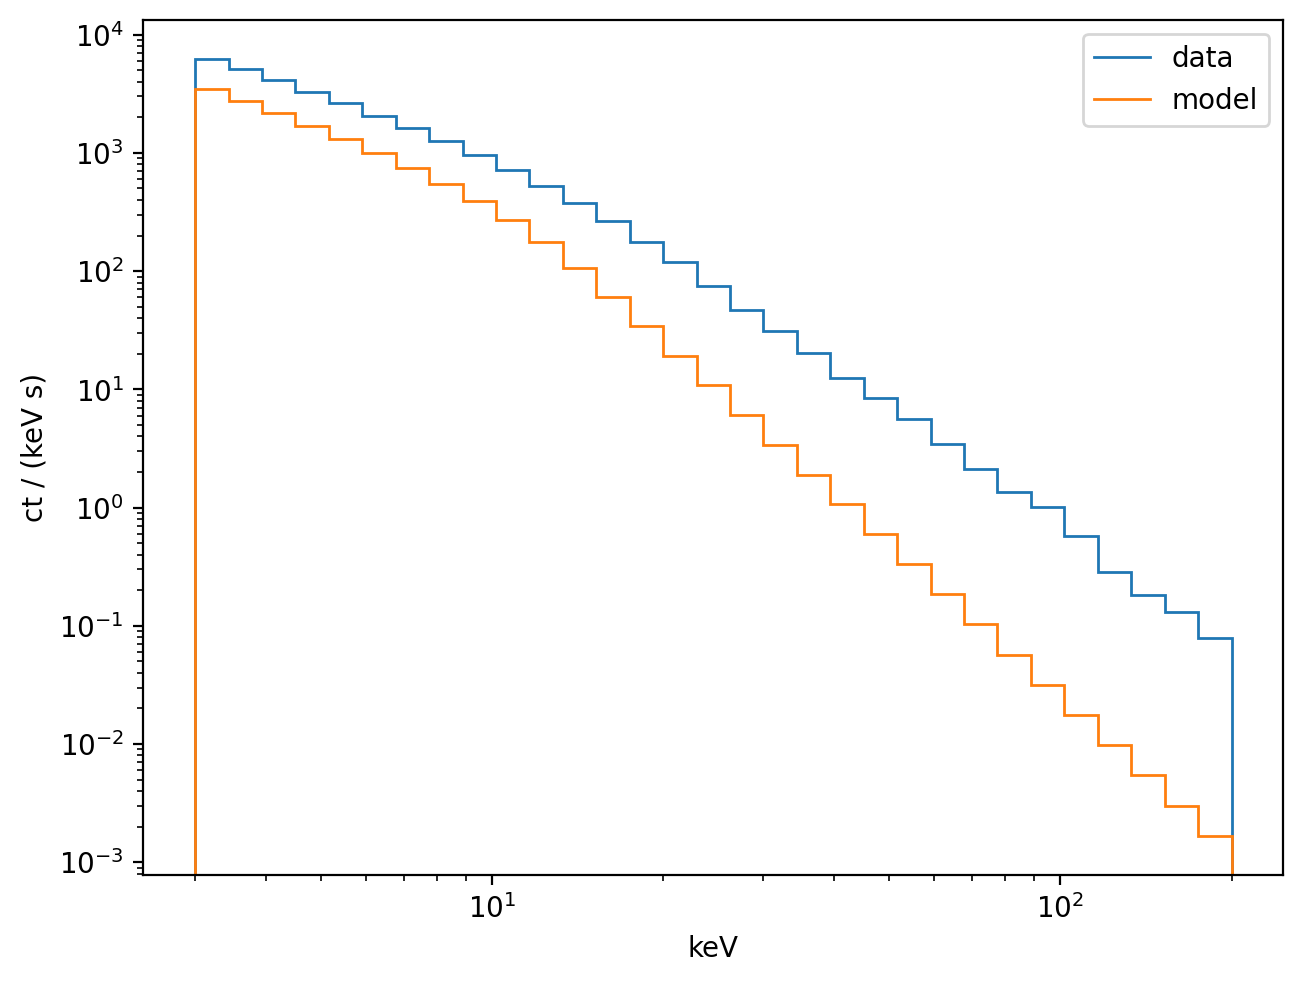

In [7]:
ph_model = mod.evaluate(photon_edges) * spectrum.photons_de
counts_model = (spectrum.response_matrix @ ph_model) / spectrum.counts_de
measured_rate = spectrum.counts / spectrum.counts_de / spectrum.effective_exposure

# Make sure units are good before plotting
counts_model = counts_model << measured_rate.unit

fig, ax = plt.subplots(layout='constrained')
ax.stairs(measured_rate.value, spectrum.count_energy_edges.value, label='data')
ax.stairs(counts_model.value, spectrum.count_energy_edges.value, label='model')
ax.set(xscale='log', yscale='log', xlabel='keV', ylabel=counts_model.unit)
ax.legend()
plt.show()

## First: fit with Nelder-Mead minimization

In [8]:
minimizer = fitters.NonlinearMinimizer(spectrum, mod)
minimizer.perform_fit(method='Nelder-Mead')

In [9]:
best_parameters = minimizer.optimize_result.x
best_parameters

array([4.00006091e+00, 1.98639863e+01, 1.01094667e+36])

## Next: fit $\chi^2$ with MCMC around global minimum

In [10]:
mod.update_parameters(*best_parameters)
mcmc = fitters.MonteCarloChi2Fitter(spectrum, mod)
print(mcmc.model_parameters())
mcmc.perform_fit(num_steps=500)

OrderedDict({'electron_index': ModelParameter<4.000060912163555 | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fee1eb5fe30>>, 'low_energy_cutoff': ModelParameter<19.863986280186722 keV | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed90955be0>>, 'electron_flux': ModelParameter<1.010946674376947e+36 electron / s | <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fed9277ecc0>>})


/home/william/Desktop/sunkitspex-dev/skitspex-dev/lib/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/william/Desktop/sunkitspex-dev/sunkit-spex/sunkit_spex/fitting/fitters.py:81: RuntimeWarning: overflow encountered in scalar add
  priors = sum(


## Now plot a few of the MCMC results

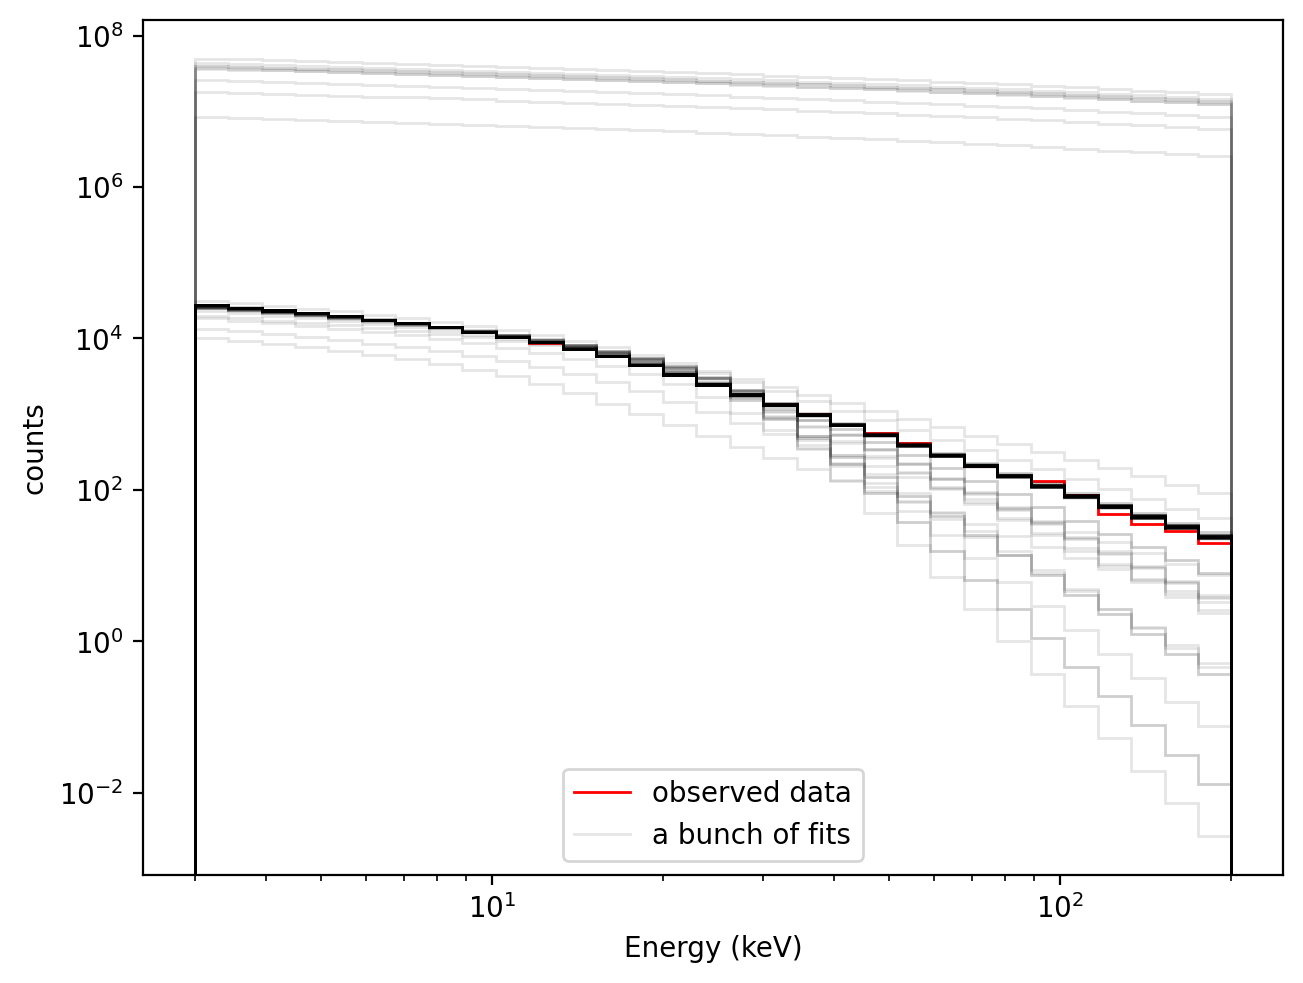

In [11]:
chain = mcmc.emcee_sampler.get_chain(flat=True)

# Remove a few of the initial "bad" samples
samples_burn = 100
indices = np.arange(chain.shape[0])

num_models_plot = 100
a_sample = np.random.choice(indices[samples_burn:], num_models_plot)
sampled_params = [chain[i] for i in a_sample]

fig, ax = plt.subplots(layout='constrained')

ax.stairs(
    spectrum.counts.to_value(u.ct),
    spectrum.count_energy_edges.to_value(u.keV),
    color='red',
    label='observed data'
)

mod = fit_models.ThickTargetBremsstrahlungSinglePowerLaw()

first_kw = {'label': 'a bunch of fits'}
for sp in sampled_params:
    mod.update_parameters(*sp)
    evald = mod.evaluate(spectrum.photon_energy_edges)
    photons = evald * spectrum.effective_exposure * spectrum.photons_de
    cts = spectrum.response_matrix @ photons

    ax.stairs(
        cts.to_value(u.ct),
        spectrum.count_energy_edges.to_value(u.keV),
        color='black', alpha=0.1,
        **first_kw
    )
    first_kw = {}

ax.legend()
ax.set(xlabel='Energy (keV)', ylabel='counts', xscale='log', yscale='log')
plt.show()

## Optionally save both results

In [12]:
import dill
import lzma

with lzma.open('thick-target-example.dill.xz', 'wb') as f:
    out = {'minimizer': minimizer, 'mcmc': mcmc}
    dill.dump(out, f)